### Lab 6

#### Desarrollado por:
- Alejandro Gómez
- Roberto Vallecillos
- Paola de León

In [16]:
# Librerias
import pandas as pd
import numpy as np
from sklearn import *
from scipy import *
import matplotlib.pyplot as plt
import seaborn as sns

### Task 1.1 Clasificación League of Legends

In [17]:
# Lectura de csv
LoLData = pd.read_csv('high_diamond_ranked_10min.csv')
LoLData.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [18]:
# Eliminar duplicados
LoLData.drop_duplicates(inplace=True)
# Eliminar valores nulos
LoLData.dropna(inplace=True)

#### Análisis exploratorio

0    0.500962
1    0.499038
Name: blueWins, dtype: float64


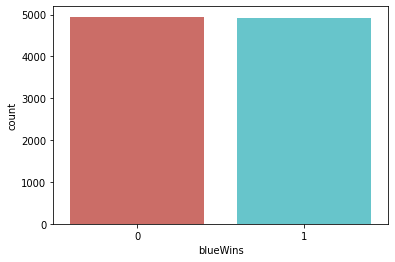

In [26]:
# Análisis exploratorio

sns.countplot(x='blueWins', data=LoLData, palette='hls')

porcentajeBlue = LoLData['blueWins'].value_counts(normalize=True)

print(porcentajeBlue)

<AxesSubplot:xlabel='blueWins', ylabel='count'>

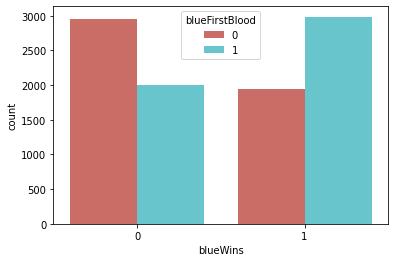

In [20]:
# Gráfico exploratorio
sns.countplot(x='blueWins', hue='blueFirstBlood', data=LoLData, palette='hls')

<AxesSubplot:>

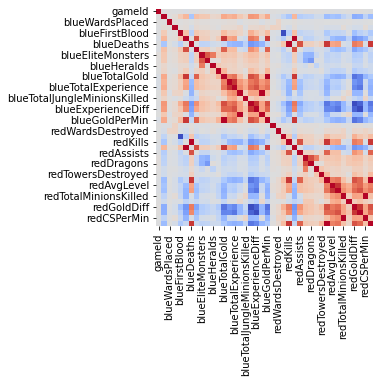

In [21]:
sns.heatmap(data=LoLData.corr(), cbar=False,  square=True, fmt='.2f', annot_kws={'size': 15}, cmap='coolwarm')

#### Proceso realizado con librerías

In [22]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

copyLol = LoLData.copy()
# Variables independientes
X = copyLol.drop(['blueWins'], axis=1)
# Variable objetivo
y = LoLData['blueWins']

# Dividir el conjunto de datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, random_state=0)

# Crear el objeto de clasificación

Tree = DecisionTreeClassifier()

# Entrenar el modelo

Tree.fit(X_train, y_train)

# Predecir el conjunto de datos de prueba

y_pred = Tree.predict(X_test)

# Metricas
accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)

# Accuracy y Precision
print("Accuracy:", accuracy)
print("Precision:", Precision)

Accuracy: 0.6437246963562753
Precision: 0.6352459016393442


In [23]:
# Representatión del arbol
representacion = tree.export_text(Tree)
print(representacion)

|--- feature_35 <= -189.50
|   |--- feature_16 <= 1770.00
|   |   |--- feature_8 <= 0.50
|   |   |   |--- feature_35 <= -828.50
|   |   |   |   |--- feature_1 <= 81.50
|   |   |   |   |   |--- feature_32 <= 18569.00
|   |   |   |   |   |   |--- feature_13 <= 18901.50
|   |   |   |   |   |   |   |--- feature_15 <= 36.50
|   |   |   |   |   |   |   |   |--- feature_6 <= 18.00
|   |   |   |   |   |   |   |   |   |--- feature_14 <= 253.00
|   |   |   |   |   |   |   |   |   |   |--- feature_20 <= 10.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- feature_20 >  10.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |--- feature_14 >  253.00
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_6 >  18.00
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_15 >  36.50
|   |   |   |   |   |